In [1]:
#EPieters HW5
#Question 1

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
import glob
from simple_read_ligo import read_file, read_template
import json
from scipy.signal.windows import tukey #for windowing
from scipy.signal import savgol_filter #for smoothing

data_dir = 'LOSC_Event_tutorial/'

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

## CONTENTS

* [Part A](#parta)
* [Part B](#partb)
* [Part C](#partc)
* [Part D](#partd)
* [Part E](#parte)
* [Part F](#partf)


In [3]:
### USEFUL FUNCTIONS

#WINDOWING: use kaiser window
#add an extended flat region at the top of the kaiser window
#default is an eigth of the window
def flattop_kaiser(m, beta, flat=1/8, DEBUG=False):
    m_win = int(m*(1-flat))
    m_win += int(m_win%2) #want an even number
    
    win = np.kaiser(m_win, beta)
    pad = np.ones(m-m_win)
    win_full= np.insert(win, int(m_win/2), pad)
    
    if DEBUG:
        mpl.figure()
        mpl.plot(win)
        mpl.plot(win_full)
        mpl.show()
    
    return win_full


#plot the FT of the data with different methods:
#without window, with kaiser window, with flat kaiser window
#returns data with flat kaiser window and with kaiser window
def examine_window_methods(data, beta, flat=1/8, DEBUG=False):
    m = len(data)
    win_kaiser = np.kaiser(m, beta)
    win_flatkaiser = flattop_kaiser(m, beta, flat)
    
    data_kaiser = data*win_kaiser
    data_flatkaiser = data*win_flatkaiser
    
    fft_data = np.fft.rfft(data)
    fft_data_kaiser = np.fft.rfft(data_kaiser)
    fft_data_flatkaiser = np.fft.rfft(data_flatkaiser)

    mpl.figure()
    mpl.plot(win_kaiser)
    mpl.plot(win_flatkaiser)
    mpl.title('Windows')
    mpl.legend(['kaiser', 'kaiser with flat top'])
    mpl.show()
    
    mpl.figure()
    mpl.loglog(np.abs(fft_data))
    mpl.loglog(np.abs(fft_data_kaiser))
    mpl.loglog(np.abs(fft_data_flatkaiser))
    mpl.title('FFT of windowed data')
    mpl.legend(['No window', 'kaiser', 'kaiser with flat top'])
    mpl.show()
    
    if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(fft_data_kaiser))
            mpl.title('FFT of kaiser windowed data')
            mpl.show()
            
            mpl.figure()
            mpl.loglog(np.abs(fft_data_flatkaiser))
            mpl.title('FFT of flat kaiser windowed data')
            mpl.show()
    
    return fft_data_flatkaiser, fft_data_kaiser


#create boxcar smooth via convolution
#have option to take maximum
def boxcar_smooth(data, m, take_max=True, DEBUG=False):
    box = np.zeros(len(data))
    #make symmetrix boxcar
    box[:m] = 1
    box[-m:] = 1
    box = box/sum(box) #normalize
    print('sum of  box should now be 1 ', sum(box))

    if DEBUG:
        mpl.figure()
        mpl.plot(box)
        mpl.title('box for boxcar smooth')
        mpl.show()

    #convolve the boxcar with the data
    smooth_data = np.fft.irfft( np.fft.rfft(data) * np.fft.rfft(box) , len(data))

    if DEBUG:
        print('is total power convserved? these should be the same ')
        print(np.mean(data), np.mean(smooth_data))

    if take_max:
        max_smooth_data = np.maximum(data, smooth_data)

        print(np.mean(max_smooth_data))

        if DEBUG:
            mpl.figure()
            mpl.loglog(np.abs(data))
            mpl.loglog(np.abs(smooth_data))
#             mpl.loglog(np.abs(max_smooth_data))
            mpl.title('max data')
#             mpl.legend(['ogirinal', 'smoothed', 'max'])
            mpl.show()

        return max_smooth_data

    return smooth_data


#function returns template based on current file name
def get_template(fname, DEBUG=False):
    with open(data_dir + 'BBH_events_v3.json') as json_file: 
        template_dict = json.load(json_file)
    for ii in template_dict:
        
        if data_dir + template_dict[ii]['fn_H1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            tname_full = data_dir + tname + '_4_template.hdf5'
            th, tl = read_template(tname_full) #read in template file
            
            if DEBUG:
                print('for file ', fname, ' reading template ', tname_full)
                
            return th 
        
        if data_dir + template_dict[ii]['fn_L1'] == fname:
            tname = template_dict[ii]['name'] #the name of the template
            tname_full = data_dir + tname + '_4_template.hdf5'
            th, tl = read_template(tname_full) #read in template file
            
            if DEBUG:
                print('for file ', fname, ' reading template ', tname_full)
                
            return tl
        
    print('ERROR: template not found for file ', fname)
    return 0

#function returns EVENT NAME for file
def get_event_and_type(fname):
    with open(data_dir + 'BBH_events_v3.json') as json_file: 
        template_dict = json.load(json_file)
    for ii in template_dict:
        
        if data_dir + template_dict[ii]['fn_H1'] == fname:
            return ii, 'Hanford'
        
        if data_dir + template_dict[ii]['fn_L1'] == fname:     
            return ii, 'Livingston'
        
    print('ERROR: event and type not found for file ', fname)
    return 0


def search_data(template, data, Nft=1):
    return np.fft.irfft( np.conj(np.fft.rfft(template)) * (np.fft.rfft(data)/Nft), len(data))

#get the SNR of the output by taking the ratio of the peak
# to the std of the rest of the data. only keep some of 
# the rest of the data as it shrinks.
def event_noise_SNR_scatter(data, keep=30000, DEBUG=False):
    sig = np.max(np.abs(data))
    idx_max = int(np.where(np.abs(data)==np.max(np.abs(data)))[0])
    idx_max +=100 #shift it off the maximum to avoid including maximum
    num = int(keep)
#     idx_noise = range(idx_max, idx_max+num)
    noise = np.std(data[idx_max:(idx_max+num)])
    
    if DEBUG:
        print('magnitude of signal', sig)
        print('magnitude of noise ', noise)
        
        mpl.figure()
        mpl.plot(data)
        mpl.plot([idx_max, idx_max], [-sig/2, sig/2], 'r-.')
        mpl.plot([idx_max+num, idx_max+num], [-sig/2, sig/2], 'r-.')
        mpl.title('signal to noise (noise is std of data btwn lines)')
        mpl.show()
    
    return sig/noise, noise

#add two numbers in quadrature. for combining SNR
def add_quad(a, b):
    return np.sqrt(a**2 + b**2)

## Part A <a name="parta"></a>

Part A displays the noise generation with debug on (printing extra plots to display the process) for one Hanford and one Livingston file.

Note that a noise model is generated for each dataset in the main problem, so Livingston and Hanford each have their own seperate noise model for each event.

### Noise model
The noise model was derived based on the data. Specifically, based on the assumption of stationary noise, I took the FT of the data into frequency space where the noise matrix should be diagonal.

The assumption was used that the noise would approximately be the same shape as the data. So the data in frequency space was squared, then windowed, then smoothed.

### Windowing
A tukey window was used for windowing since it has an extended flat part near the center, which prevents tapering the signal off too early. (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.tukey.html)

Previous windows included kaiser (rejected because it didn't quite go to zero and introduced spurious peaks at the center) and the cosine window. These can still be selected in the main function.

### Smoothing
Savisky Golay filtering is used on the frequency domain power spectrum to smooth out the shape. This low pass filter keeps the shape and features of the data better than moving averages (https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html). However it does seem to fare worse in terms of conserving power, as it increases the power.

Previous smoothing included a boxcar filter.

In order to deal with the peaks, which indicate bad data that we want to weight badly, we took the maximum of the smoothed and unsmoothed noise model. This means that peaks will not be smoothed out, and bad data will be correctly rejected. Note that choosing the maximum also means that the overall energy of the signal is increased.


In [4]:
### FUNCTION FOR GENERATING NOISE MODEL ###

#returns noise model in fourier space (Nft) and smoothing window
#can choose between windows for TUKEY, KAISER, or COS
    #parameters for TUKEY: alpha
    #for KAISER: beta
#can choose between smoothing for SAVGOL and BOXCAR
    #parameters for SAVGOL: smooth_len (ODD), polyorder
    #parameters for BOXCAR: smooth_len
def noise_model(strain, window='TUKEY', smooth='SAVGOL', alpha=0.5, beta=5, \
                smooth_len=15, polyorder=1, TAKE_MAX=True, DEBUG=False):
    
    ### WINDOWING AND SMOOTHING ###
    #get different windowing methods
    USE_TUKEY = (window == 'TUKEY')
    USE_KAISER = (window == 'KAISER')
    USE_COS = (window == 'COS')

    #get different smoothing methods
    USE_BOXCAR = (smooth == 'BOXCAR')
    USE_SAVGOL = (smooth == 'SAVGOL')

    if USE_KAISER: 
        #BAD DON'T USE THIS INTRODUCES SPURIOUS CORRELATION IN CENTER WTF WHY HOW
        #BECAUSE IT DOESN'T GO TO ZERO AT THE EDGES THATS WHY
        #kaiser filter is tried due to the adjustability, can be similar to hanning, hamming, blackman filter
        # simply by adjusting beta
        #also to extend flat period in middle to avoid diminishing important signals too much
        #compares kaiser window with and without flat period. with flat period is chosen.
#         beta = 5
        flat = 0.4
        fft_data_flatkaiser, fft_data_kaiser = examine_window_methods(strain, beta, flat, DEBUG=False)

        if True:
            win = flattop_kaiser(len(strain), beta, flat) # will need this window later
            fft_data_win = fft_data_flatkaiser
        else:
            win = np.kaiser(len(strain), beta)
            fft_data_win = fft_data_kaiser


    if USE_TUKEY:
        # TUKEY window
#         alpha = 0.5
        win = tukey(len(strain), alpha) #use scipy's tukey window
        fft_data_win = np.fft.rfft(win*strain)
        
        if DEBUG:
            mpl.figure()
            mpl.plot(win)
            mpl.title('tukey window alpha ' + repr(alpha))
            mpl.show()

    if USE_COS:
        theta = np.linspace(-np.pi, np.pi, len(strain))
        win = 0.5 + 0.5*np.cos(theta)
        fft_data_win = np.fft.rfft(win*strain)

    #different kinds of smoothing
    if USE_BOXCAR:
        #noise matrix take as windowed data squared: now SMOOTH it.
        smooth_len = 5
        Nft = boxcar_smooth(np.abs(fft_data_win)**2, smooth_len, take_max = False, DEBUG=False)
        print(max(np.imag(Nft)))

    if USE_SAVGOL:
        #smooth_len = 15
        #polyorder = 2
        Nft = savgol_filter(np.abs(fft_data_win)**2, smooth_len, polyorder)

    Nft_max = np.maximum(Nft, np.abs(fft_data_win)**2)

    if DEBUG:
        print('check that power is conserved')
        print(np.mean(Nft), np.mean(Nft_max), np.mean(np.abs(fft_data_win)**2))


        #examine effects on smoothing in frequency domain
        mpl.figure()
        mpl.loglog(np.abs(np.fft.fft(strain)**2))
        mpl.loglog(np.abs(fft_data_win)**2)
        mpl.loglog(Nft)
        mpl.title('Abs value squared of strain FFT after windowing and smoothing')
        mpl.legend(['original', 'windowed', 'windowed and smoothed'])
        mpl.show()

        mpl.figure()
        mpl.loglog(Nft)
        mpl.title('Noise model')
        mpl.show()

        mpl.figure()
        mpl.loglog(Nft_max)
        mpl.title('Noise model (maximum of smoothed and non smoothed)')
        mpl.show()
    
    if TAKE_MAX:
        
        mpl.figure()
        mpl.loglog(Nft_max)
        mpl.title('Final noise model')
        mpl.show()
        
        return Nft_max, win
    
    mpl.figure()
    mpl.loglog(Nft)
    mpl.title('Final noise model')
    mpl.show()
    
    return Nft, win

[['LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5'
  'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5'
  'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5'
  'LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5']
 ['LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5'
  'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5'
  'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5'
  'LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5']]
Events are: ('GW170104', 'GW150914', 'LVT151012', 'GW151226')

 
current file is  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Livingston')


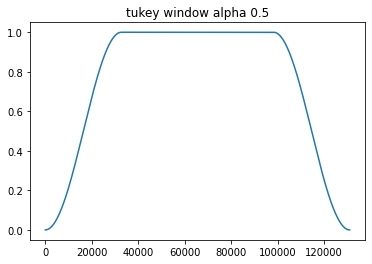

check that power is conserved
2.27635991450319e-31 3.495842551656516e-31 1.861205167324692e-31


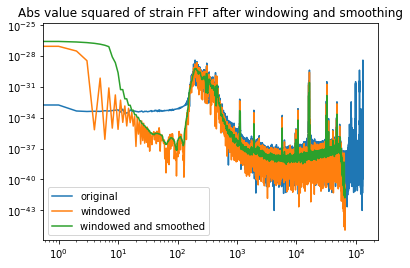

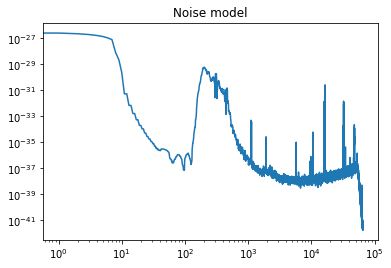

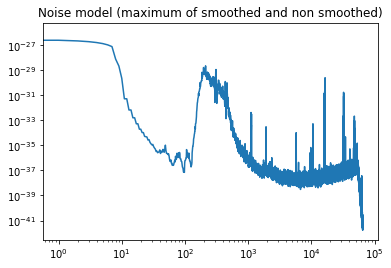

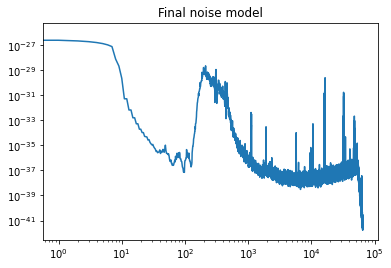


 
current file is  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Hanford')


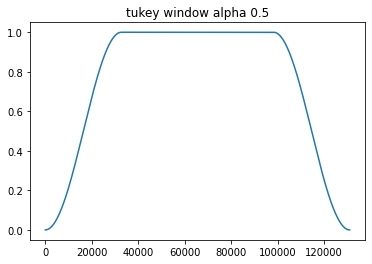

check that power is conserved
4.671878448223374e-33 6.50962767040077e-33 4.6697048514265154e-33


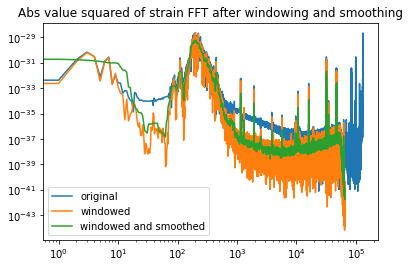

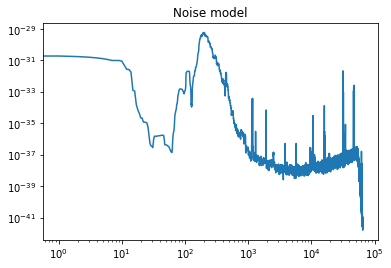

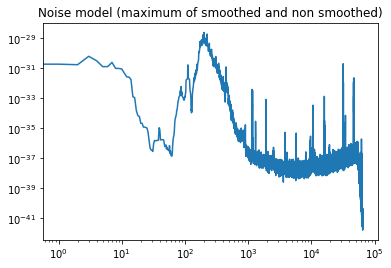

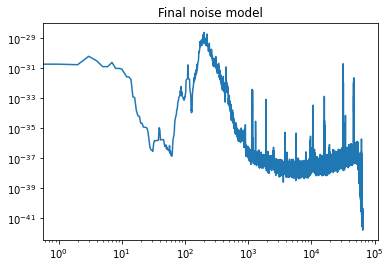

In [5]:
#PART A: come up with a noise model

### READ IN DATA ###
livingston_files = glob.glob(data_dir + "L-*.hdf5")
hanford_files = glob.glob(data_dir + "H-*.hdf5")

#index: [L/H, #]
files = np.array([livingston_files, hanford_files])
files = np.sort(files) #nice to have them in order so events are aligned
print(files)

events = () #get the events in order
for kk in range(0, 4):
    events = events + (get_event_and_type(files[0, kk])[0],)
print('Events are:', events)
    
#run a single file with debug on to demonstrate function
fname = files[0, 1]
print('\n \ncurrent file is ', fname)
print('event and type are :', get_event_and_type(fname) )
strain, dt, utc = read_file(fname)

Nft, win = noise_model(strain, window='TUKEY', smooth='SAVGOL', alpha = 0.5, smooth_len = 15, \
                polyorder=1, TAKE_MAX = True, DEBUG=True)


#run a single file with debug on to demonstrate function
fname = files[1, 1]
print('\n \ncurrent file is ', fname)
print('event and type are :', get_event_and_type(fname) )
strain, dt, utc = read_file(fname)

Nft, win = noise_model(strain, window='TUKEY', smooth='SAVGOL', alpha = 0.5, smooth_len = 15, \
                polyorder=1, TAKE_MAX = True, DEBUG=True)

## Part B <a name="partb"></a>

A correlation is used to search the data for an event. The noise model is generated based on the data in each file, and is displayed along with final cross correlation output. The peak in the output displays the match.


 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5
event and type are : ('GW170104', 'Livingston')


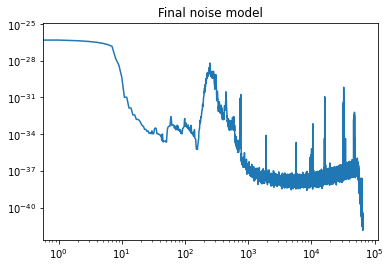

for file  LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5  reading template  LOSC_Event_tutorial/GW170104_4_template.hdf5


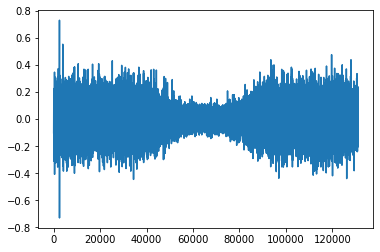


 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5
event and type are : ('GW170104', 'Hanford')


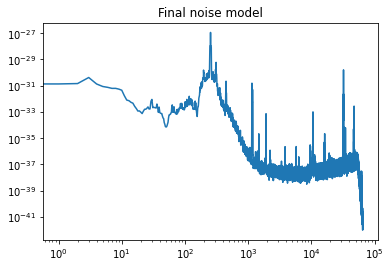

for file  LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5  reading template  LOSC_Event_tutorial/GW170104_4_template.hdf5


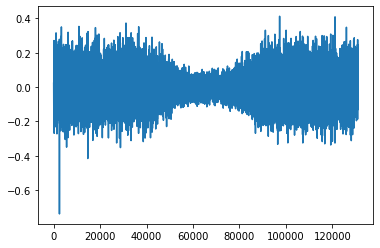


 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Livingston')


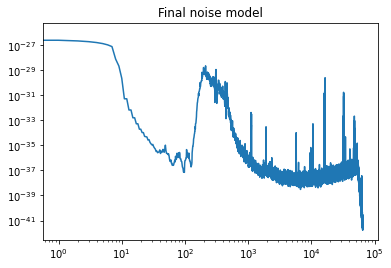

for file  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5  reading template  LOSC_Event_tutorial/GW150914_4_template.hdf5


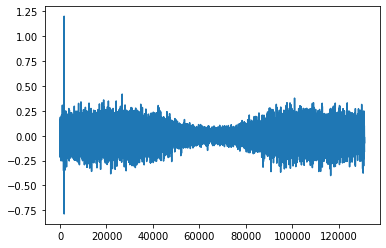


 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Hanford')


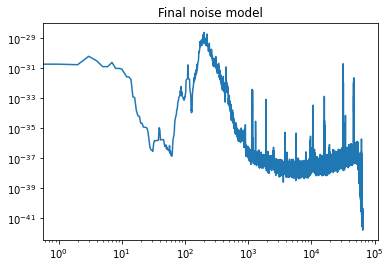

for file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5  reading template  LOSC_Event_tutorial/GW150914_4_template.hdf5


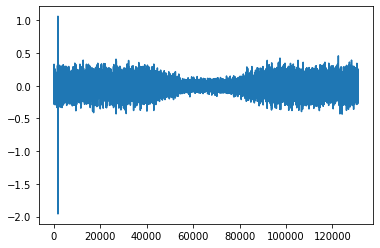


 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5
event and type are : ('LVT151012', 'Livingston')


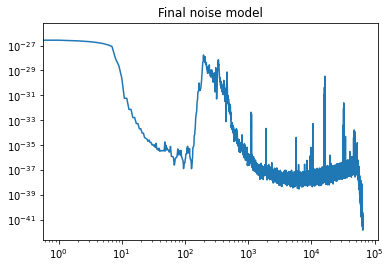

for file  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5  reading template  LOSC_Event_tutorial/LVT151012_4_template.hdf5


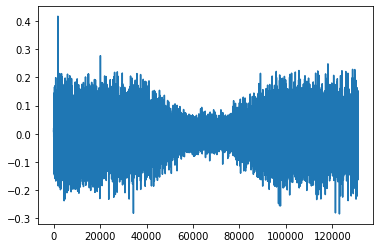


 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5
event and type are : ('LVT151012', 'Hanford')


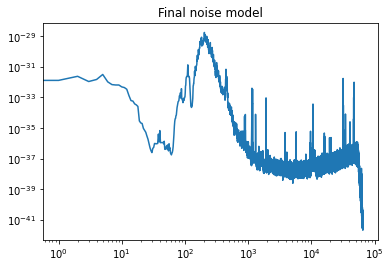

for file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5  reading template  LOSC_Event_tutorial/LVT151012_4_template.hdf5


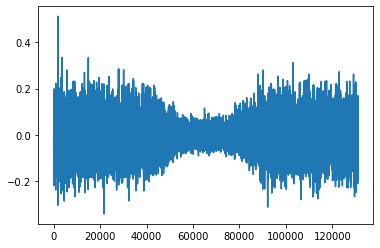


 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Livingston')


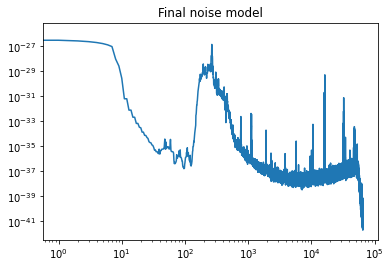

for file  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5  reading template  LOSC_Event_tutorial/GW151226_4_template.hdf5


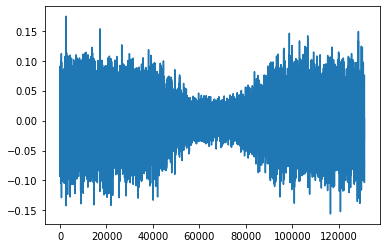


 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


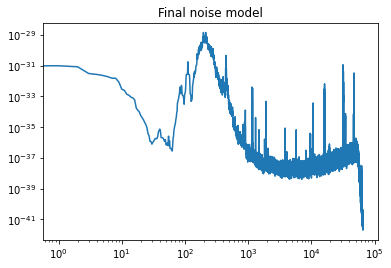

for file  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5  reading template  LOSC_Event_tutorial/GW151226_4_template.hdf5


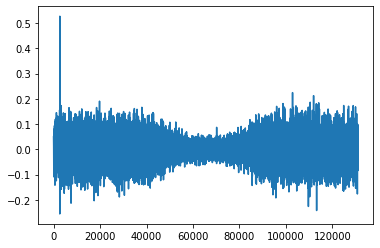

In [6]:
#PART B

#save matched filter output, noise, and window info
data_len = 131072 #yayyy! miraculously the same for all files
data_rfft_len = 65537

corr_output_all = np.zeros((2, 4, data_len))
Nft_all = np.zeros((2, 4, data_rfft_len))
win_all = np.zeros((2, 4, data_len))
template_all = np.zeros((2, 4, data_len))
dt_all = np.zeros((2, 4))


for kk in range(0, 4): #each event
    for ii in range(0, 2): #livingston and hanford
        
        #read in the appropriate file
        fname = files[ii, kk]
        print('\n \n BEGINNING FILE ', fname)
        print('event and type are :', get_event_and_type(fname) )
        strain, dt, utc = read_file(fname)

        Nft, win = noise_model(strain, window='TUKEY', smooth='SAVGOL', alpha = 0.5, smooth_len = 15, \
                        polyorder=1, TAKE_MAX = True, DEBUG=False)
        

        #get the appropriate template for this data file
        template = get_template(fname, DEBUG=True)

        #window the template and the data, as noise has been windowed
        template_win = template*win
        strain_win = strain*win

        #perform a correlation taking into account the windowed, smoothed noise in fourier space
        search = search_data(template_win, strain_win, Nft)

        mpl.figure()
        mpl.plot(search)
        mpl.show()
        
        #save the data
        corr_output_all[ii, kk, :] = search
        Nft_all[ii, kk, :] = Nft
        win_all[ii, kk, :] = win
        template_all[ii, kk, :] = template
        dt_all[ii, kk] = dt

## Part C <a name="partc"></a>

The noise is estimated from the standard deviation of the data (where there is not a significant narrowing effect from the windowing). The signal to noise ratio is taken by dividing the signal peak by the noise.

The following shows the areas taken to determine the noise, as well as the peak.

A summary of the data is printed at the bottom.


 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5
event and type are : ('GW170104', 'Livingston')
magnitude of signal 0.7306603370493083
magnitude of noise  0.12222094759492644


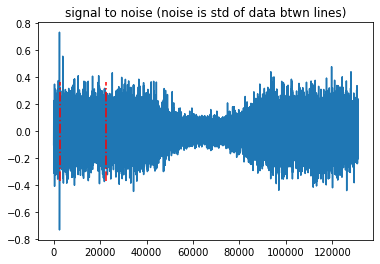

signal to noise ratio is 5.978192375589461

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5
event and type are : ('GW170104', 'Hanford')
magnitude of signal 0.7384706625377406
magnitude of noise  0.09512841926857116


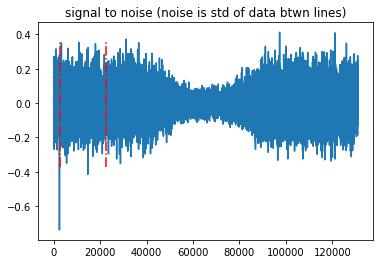

signal to noise ratio is 7.762881673171237

 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Livingston')
magnitude of signal 1.2021034892598959
magnitude of noise  0.10163830553793637


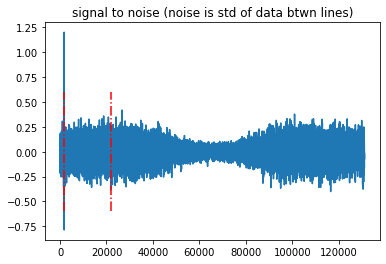

signal to noise ratio is 11.82726810426028

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Hanford')
magnitude of signal 1.9599315381286138
magnitude of noise  0.11093969519931315


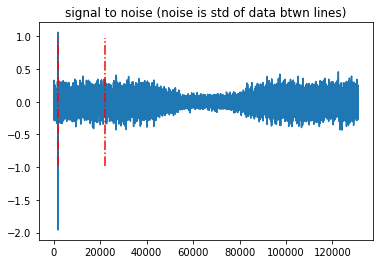

signal to noise ratio is 17.666638930343375

 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5
event and type are : ('LVT151012', 'Livingston')
magnitude of signal 0.41601461604950063
magnitude of noise  0.07277087351466117


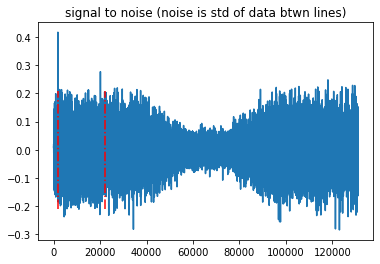

signal to noise ratio is 5.716773702952542

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1128678884-32.hdf5
event and type are : ('LVT151012', 'Hanford')
magnitude of signal 0.5124187150974995
magnitude of noise  0.07976972746646313


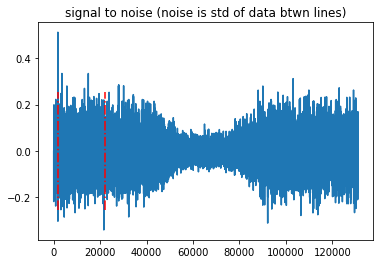

signal to noise ratio is 6.423724028804425

 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Livingston')
magnitude of signal 0.17419610500339047
magnitude of noise  0.03938143821522959


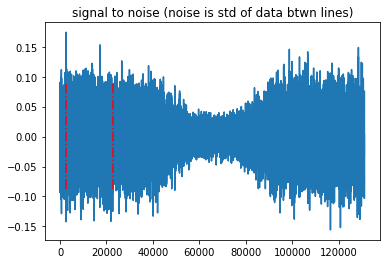

signal to noise ratio is 4.423304808000267

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')
magnitude of signal 0.5269678954098589
magnitude of noise  0.05331526521035063


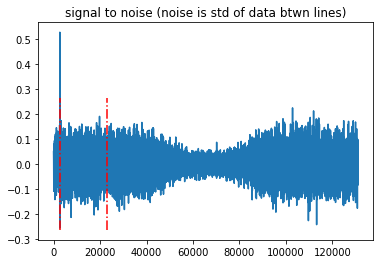

signal to noise ratio is 9.883996512645187

 
 
SUMMARY:
for event  GW170104
    livingston SNR:      5.978192375589461
    livingston noise:    0.12222094759492644
    hanford SNR:         7.762881673171237
    hanford noise:       0.09512841926857116
    combined event SNR : 9.798015919114125
for event  GW150914
    livingston SNR:      11.82726810426028
    livingston noise:    0.10163830553793637
    hanford SNR:         17.666638930343375
    hanford noise:       0.11093969519931315
    combined event SNR : 21.260159968946063
for event  LVT151012
    livingston SNR:      5.716773702952542
    livingston noise:    0.07277087351466117
    hanford SNR:         6.423724028804425
    hanford noise:       0.07976972746646313
    combined event SNR : 8.599170423302999
for event  GW151226
    livingston SNR:      4.423304808000267
    livingston noise:    0.03938143821522959
    hanford SNR:         9.883996512645187
    hanford noise:       0.05331526521035063
    combined event SNR : 10

In [7]:
#PART C: use other formula

#TODO: how to get SNR for COMBINED events?? multiply.....??

SNR_all = np.zeros((2, 4))
noise_all = np.zeros((2,4))

for kk in range(0, 4): #each event
    for ii in range(0, 2): #livingston and hanford
        fname = files[ii, kk]
        print('\n \n BEGINNING FILE ', fname)
        print('event and type are :', get_event_and_type(fname) )
        SNR_all[ii, kk], noise_all[ii, kk] = event_noise_SNR_scatter(corr_output_all[ii, kk, :], keep=20000, DEBUG=True)
        print('signal to noise ratio is', SNR_all[ii, kk])

#combine SNR of the events in quadrature
combined_SNR = np.sqrt( SNR_all[0, :]**2 + SNR_all[1, :]**2 )

print('\n \n \nSUMMARY:')
for kk in range(0, 4): #each event
    print('for event ', events[kk])
    print('    livingston SNR:     ', SNR_all[0, kk])
    print('    livingston noise:   ', noise_all[0, kk])
    print('    hanford SNR:        ', SNR_all[1, kk])
    print('    hanford noise:      ', noise_all[1, kk])
    print('    combined event SNR :', combined_SNR[kk])

## Part D <a name="partd"></a>

Find the analytic signal to noise ratio: $m / \sigma_m$.

From JS lecture ~19 minutes we find that the signal m is:

$ m = (A^T N^{-1} A)^{-1}(A^T N^{-1}d) $

This m is already being calculated by the correlation. We want the max point that acutally corresponds to the signal. So we take max( correlation ).

To find $\sigma_m$ we first transform the matrices into a prewhitened space that lives in the frequency domain, so that we can more easily use our N.

In the prewhitened space: $A'$ = FFT(A)/$\sigma$ where $\sigma = N^{1/2}$.

Then we take the inverse FFT of our $A'$ back into the time domain and because it's real use:

$\sigma_m = 1/\sqrt{IRFFT(A')^\dagger IRFFT(A')} = 1/\sqrt{IRFFT(A')^2}$

In [8]:

for kk in range(0, 4): #each event
    for ii in range(0, 2): #livingston and hanford
        fname = files[ii, kk]
        print('\n \n BEGINNING FILE ', fname)
        print('event and type are :', get_event_and_type(fname) )

        m = max(np.abs(corr_output_all[ii, kk])) #signal is max of correlation

        #need to get matrix into prewhitened form, go into FT and divide by N^1/2
        template_win = template_all[ii, kk]*win_all[ii, kk]

        A_white_fft = np.fft.rfft(template_win)/(Nft_all[ii, kk]**(1/2))
        A_white = np.fft.irfft(A_white_fft)
        
        sig_m = 1/np.sqrt( np.sum(A_white**2))
        print('\n analytic SNR for A is   ', m/sig_m)
        print('scatter SNR noise ratio is ', SNR_all[ii, kk])



 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V1-1167559920-32.hdf5
event and type are : ('GW170104', 'Livingston')

 analytic SNR for A is    36.499900649826735
scatter SNR noise ratio is  5.978192375589461

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V1-1167559920-32.hdf5
event and type are : ('GW170104', 'Hanford')

 analytic SNR for A is    29.210414292810903
scatter SNR noise ratio is  7.762881673171237

 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Livingston')

 analytic SNR for A is    49.84329882176564
scatter SNR noise ratio is  11.82726810426028

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1126259446-32.hdf5
event and type are : ('GW150914', 'Hanford')

 analytic SNR for A is    93.2333781958014
scatter SNR noise ratio is  17.666638930343375

 
 BEGINNING FILE  LOSC_Event_tutorial/L-L1_LOSC_4_V2-1128678884-32.hdf5
event and type are : ('LVT151012', 'Livingston')

 analytic SNR for A is    11

The analytic signal to noise ratio is too high. The noise model believes that the noise is much smaller then it is, likely because the noise model has been windowed down at the edges. In the correlation output, we took the noise from the standard deviation of the area that had not been significantly windowed down (between the two red lines); if we had taken the standard deviation of the windowed area we would have gotten a smaller noise, and therefore a higher SNR, as the analytic one would have us believe.

The exception is the last two, which actually have a lower SNR; I looking at the corresponding plots for the scatter SNR it seems that other areas have noisy spikes not included in the standard deviation that I took resulting in the scatter having a lower noise and higher SNR; but the noise model sees all of these and makes a lower analytic SNR.

## Part E <a name="parte"></a>

Rewriting $\chi^2$ as in JSievers' lecture from Nov. 4 (~9mins) we find that

$ \chi^2 = (\frac{d'}{\sigma} - \frac{A'}{\sigma} m )^\dagger(\frac{d'}{\sigma} - \frac{A'}{\sigma} m ) )$

where 

$A' = FFT(A)$

$d' = FFT(d)$

Here we see that in this form, by including the noise in the $\sigma$ inside the equation, we can say that the noise is the identity matrix. The contributions to the signal from each frequency mode in our model is the factor in front of $m$: it's $\frac{A'}{\sigma}$ for each point. Essentially what that breaks into is the model at each frequency ($A'$) weighted by the noise in that frequency ($\sigma$).

The contribution to the overall $\chi^2$ the weights for the frequency modes are that same prefactor squared, aka:

$(\frac{A'}{\sigma})^2$

When not plotted in a loglog plot we can see that the lower frequencies contribute significantly; it's definitely skewed to lower frequencies.

We also plot the normalized cumuluative sum of this weighting to highlight along with a line at 0.5 to highlight the frequency at which half the weight comes from higher frequencies and half from lower. This frequency is notably low for all events.


 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


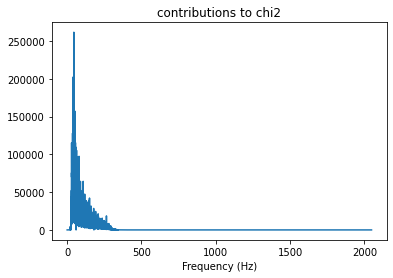

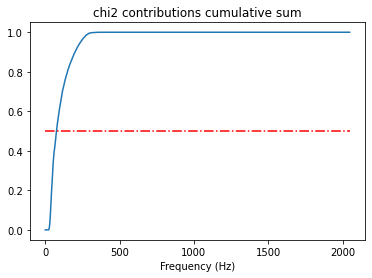

closest idx is :  2413
freq with half weight above and below :  75.40625  Hz

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


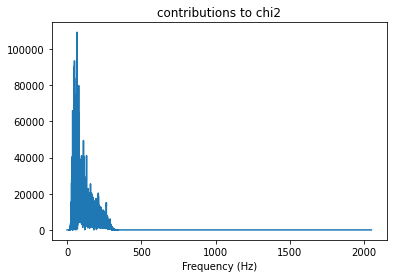

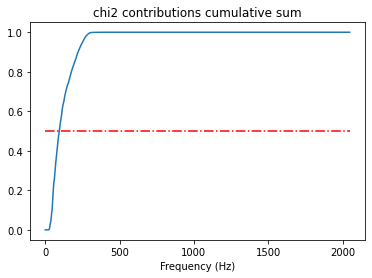

closest idx is :  2980
freq with half weight above and below :  93.125  Hz

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


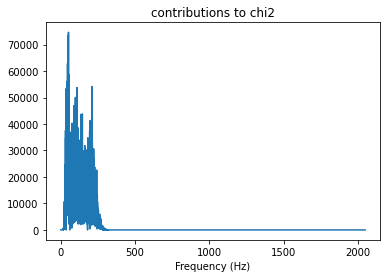

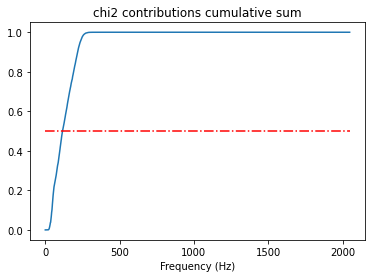

closest idx is :  3715
freq with half weight above and below :  116.09375  Hz

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


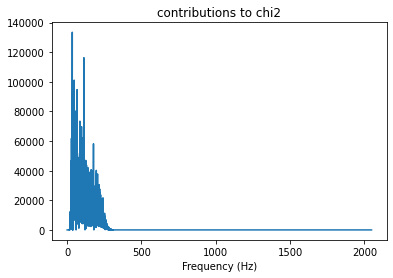

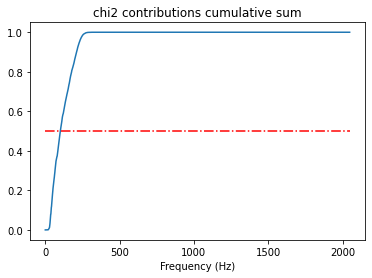

closest idx is :  3236
freq with half weight above and below :  101.125  Hz

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


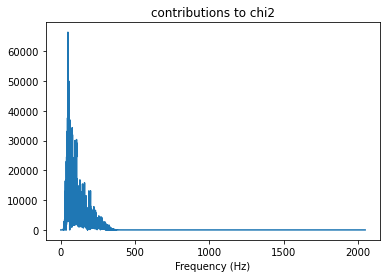

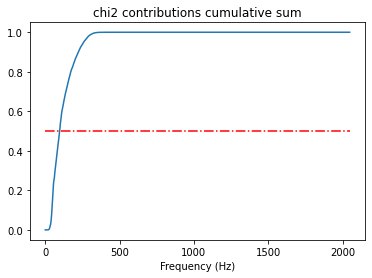

closest idx is :  3081
freq with half weight above and below :  96.28125  Hz

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


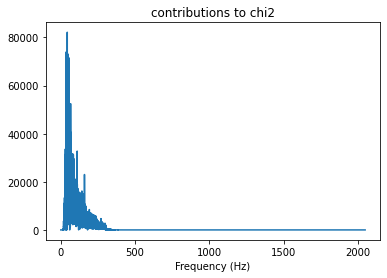

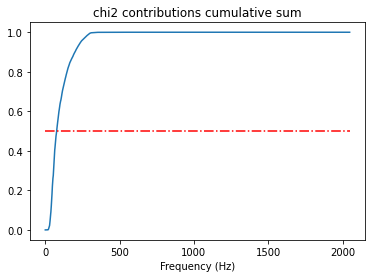

closest idx is :  2446
freq with half weight above and below :  76.4375  Hz

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


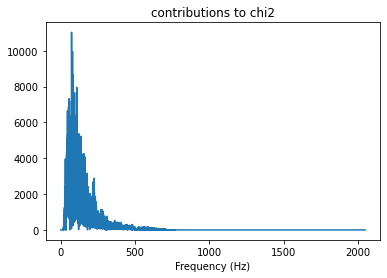

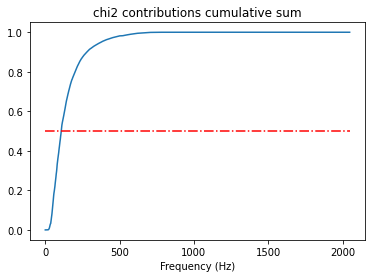

closest idx is :  3429
freq with half weight above and below :  107.15625  Hz

 
 BEGINNING FILE  LOSC_Event_tutorial/H-H1_LOSC_4_V2-1135136334-32.hdf5
event and type are : ('GW151226', 'Hanford')


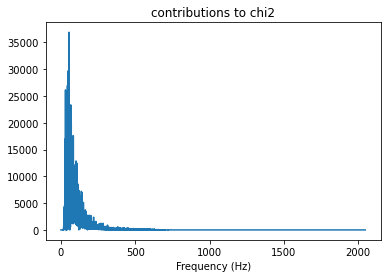

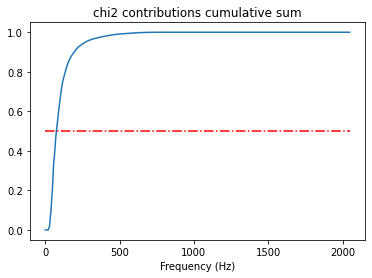

closest idx is :  2394
freq with half weight above and below :  74.8125  Hz


In [9]:
#PART E:

def find_halfway_freq(template, win, Nft, dt):
    template_win_fft = np.fft.rfft(template*win)
    sig = Nft**(1/2) #standard deviation for each data point - in fourier space, so each frequency
    chi2_weight = (template_win_fft / sig)**2 #weight that each data point (frequency) adds to chi squared
    freqs = np.fft.rfftfreq(len(strain), dt)

    mpl.figure()
    mpl.plot(freqs, np.abs(chi2_weight))
    mpl.title('contributions to chi2')
    mpl.xlabel('Frequency (Hz)')
    mpl.show()

    #normalize and take the cumulative sum so half weighting is at 0.5
    chi2_weight_csum = np.cumsum( np.abs(chi2_weight) / np.sum(np.abs(chi2_weight)))

    mpl.figure()
    mpl.plot(freqs, chi2_weight_csum)
    mpl.plot([min(freqs), max(freqs)], [0.5, 0.5], 'r-.')
    mpl.title('chi2 contributions cumulative sum')
    mpl.xlabel('Frequency (Hz)')
    mpl.show()

    idx_half = np.argmin(np.abs(chi2_weight_csum - 0.5))
    print('closest idx is : ', idx_half)
    print('freq with half weight above and below : ', freqs[idx_half], ' Hz')
    
    
for kk in range(0, 4): #each event
    for ii in range(0, 2): #livingston and hanford
        print('\n \n BEGINNING FILE ', fname)
        print('event and type are :', get_event_and_type(fname) )
        find_halfway_freq(template_all[ii, kk], win_all[ii, kk], Nft_all[ii, kk], dt_all[ii, kk])
        

In [10]:
# #PART E do with only noise
# #check when weights are cumulatively 1/2
# freqs = np.fft.rfftfreq(len(strain), dt)
# Nft_norm_csum = np.cumsum(Nft/sum(Nft))

# mpl.figure()
# mpl.loglog(freqs, Nft_norm_csum)
# # mpl.loglog(Nft_norm_csum)
# mpl.loglog([min(freqs), max(freqs)], [0.5, 0.5], 'r-.')
# mpl.xlabel('freq (Hz)')
# mpl.show()

# idx_half = np.argmin(np.abs(Nft_norm_csum - 0.5))
# print(idx_half)
# print('closest idx, freq is : ', idx_half, freqs[idx_half])

## Part F <a name="partf"></a>

The time of arrival is the timestamp of the maximum of the correlation. This can be localized within plus or minus one index, which corresponds $\pm dt$. An example from one of the events is plotted, zoomed in on the peak region, where the highest correlation can be seen. A more advances method may be to actually fit these peaks with some shape (ie gaussian or other similar peak) to get an even more precise value, and a more accurate value on the error. For the purposes of this assignment the $\pm dt$ seemed sufficient.

The error in arrival time corresponds to an error in the angular positional uncertainty of the source on the sky. Specifically, it is the error in the difference in arrival times at the two detectors that causes the uncertainty. This error we will call $\Delta t = \sqrt{dt^2 + dt^2} = \sqrt{2}dt$, where $dt$ is the change in time from index to index in the data and therefore the error on arrival time at a sigle detector.

Here we derive the relationship between the difference in arrival times ($t_d$) and the angular position from the normal $\theta$, along with the resulting angular uncertainty ($\Delta \theta$) from the error in $t_d$ ($\Delta t$).

<img src = partfderivation.jpg>

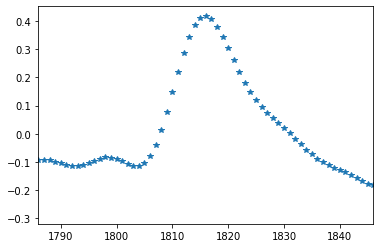

1816

In [11]:
# PART F
#time difference, gives path length difference on sky, gives a ring of where it's coming from.
# how WELL can we LOCALIZE it. look closer at correlation

def localize_event(data):
    
    idx_max = int(np.where(np.abs(data)==np.max(np.abs(data)))[0])

    zoom = 30
    mpl.figure()
    mpl.plot(data, '*')
    mpl.xlim([-zoom + idx_max, zoom + idx_max])
    mpl.show()
    
    return idx_max

localize_event(corr_output_all[0, 2])
#can generally localize to within 2 dt. two timesteps.

The average error (taking the average of cos($\theta$) from 0 to $\pi$) is calculated below, in both degrees and radians.

In [13]:
#pick a file, any file
fname = files[0, 2]
strain, dt, utc = read_file(fname)

dtheta = 1/2 * np.sqrt(2) * dt * (3*10**8) / 5000
dtheta_rad = dtheta * np.pi/180

print('typical errors:')
print('   degrees:', dtheta)
print('   radians:', dtheta_rad)

typical errors:
   degrees: 10.358009490037318
   radians: 0.18078136955397


This is a large angular error on the sky. It can possibly be reduced by fitting the peaks and obtaining a smaller dt, or by adding more detectors to help narrow down the area.